In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load

In [2]:
# get_data, process_data, fiducial_cuts, fiducial_cuts_all, aperture_parametrisation, check_aperture
from processing import *

run_histograms = False

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

m_Z = 91.1876 # GeV
m_mu = 105.6583745e-03 # GeV
m_p = 938.2720813e-03 # GeV

#PX_ += pt_ * np.cos( phi_ )
#PY_ += pt_ * np.sin( phi_ )
#PZ_ += pt_ * np.sinh( eta_ )
#E_  += np.sqrt( np.cosh( eta_ )**2 + m_**2 )
class MissingMass:
    def __call__(self, momenta):
        #ECM_ = 13000.
        #PX_ = 0.; PY_ = 0.; PZ_ = 0.; E_ = 0.;
        #for idx_ in range( len(momenta) ):
        #    PX_ += momenta[idx_][0]
        #    PY_ += momenta[idx_][1]
        #    PZ_ += momenta[idx_][2]
        #    E_  += momenta[idx_][3]
        mom_ = np.sum( momenta, axis=0 )
        #PX_ = mom_[0]; PY_ = mom_[1]; PZ_ = mom_[2]; E_ = mom_[3];
        return np.sqrt( np.max( [ 0., (13000. - mom_[3])**2 - mom_[0]**2 - mom_[1]**2 - mom_[2]**2 ] ) )
    
#def select_data( df_ ):
#    df__ = df_[ ( df_["InvMass"] >= ( m_Z - 10.) ) & ( df_["InvMass"] <= ( m_Z + 10.) ) ]
#    return df__

class SelectData():
    def __init__(self, proton_selection=""):
        self.proton_selection_ = proton_selection
    def __call__(self, df_):
        df_ = df_[ ( np.abs( df_["Muon0Eta"] ) <= 2.4 ) & ( np.abs( df_["Muon1Eta"] ) <= 2.4 ) &
                   ( df_["InvMass"] >= ( m_Z - 10.) ) & ( df_["InvMass"] <= ( m_Z + 10.) ) ]

        #df_ = process_data( df_, self.proton_selection_, min_mass = 0. )

        df_ = df_.set_index( ["Run", "LumiSection", "EventNum", "Slice"], drop=False )

#        if proton_selection == "MultiRP":
#            msk_ = df_.groupby( ["Run", "LumiSection", "EventNum", "Slice"] ).apply(
#                        lambda df__:
#                            ( np.sum( ( df__[ "MultiRP" ] == 1 ) & ( df__[ "Arm" ] == 0 ) ) >= 1 ) and ( np.sum( ( df__[ "MultiRP" ] == 1 ) & ( df__[ "Arm" ] == 1 ) ) >= 1 )
#                        )
#            print( msk_)
#
#            df_ = df_.loc[ msk_ ]
#            df_[ "MX" ] = df_.groupby( ["Run", "LumiSection", "EventNum", "Slice"] ).apply(
#                            lambda df__:
#                                13000. * np.sqrt( df__.iloc[0].Xi * df__.iloc[1].Xi )
#                            )
#            pz_sign_ = { 0: -1, 1: 1}
#            pbeam_ = 6500.
#            df_[ "MissingMass" ] = df_.groupby( ["Run", "LumiSection", "EventNum", "Slice"] ).apply(
#                lambda df__:
#                    MissingMass()(
#                        [ np.array( [ df__.iloc[0].Muon0Pt*np.cos(df__.iloc[0].Muon0Phi),
#                                      df__.iloc[0].Muon0Pt*np.sin(df__.iloc[0].Muon0Phi),
#                                      df__.iloc[0].Muon0Pt*np.sinh(df__.iloc[0].Muon0Eta),
#                                      np.sqrt( np.cosh(df__.iloc[0].Muon0Eta)**2 + m_mu**2 ) ] ),
#                          np.array( [ df__.iloc[0].Muon1Pt*np.cos(df__.iloc[0].Muon1Phi),
#                                      df__.iloc[0].Muon1Pt*np.sin(df__.iloc[0].Muon1Phi),
#                                      df__.iloc[0].Muon1Pt*np.sinh(df__.iloc[0].Muon1Eta),
#                                      np.sqrt( np.cosh(df__.iloc[0].Muon1Eta)**2 + m_mu**2 ) ] ),
#                          np.array( [ pbeam_ * (1. - df__.iloc[0].Xi) * df__.iloc[0].ThX,
#                                      pbeam_ * (1. - df__.iloc[0].Xi) * df__.iloc[0].ThY,
#                                      pz_sign_[ df__.iloc[0].Arm ] * pbeam_ * (1. - df__.iloc[0].Xi),
#                                      np.sqrt( pow( pbeam_ * (1. - df__.iloc[0].Xi), 2 ) + m_p**2 ) ] ),
#                          np.array( [ pbeam_ * (1. - df__.iloc[1].Xi) * df__.iloc[1].ThX,
#                                      pbeam_ * (1. - df__.iloc[1].Xi) * df__.iloc[1].ThY,
#                                      pz_sign_[ df__.iloc[1].Arm ] * pbeam_ * (1. - df__.iloc[1].Xi),
#                                      np.sqrt( pow( pbeam_ * (1. - df__.iloc[1].Xi), 2 ) + m_p**2 ) ] )
#                        ] )
#                )
        return df_


### Example data

In [ ]:
fileNames_data = [
    #'output-UL2017B-PreSel-Pt1_30-Pt2_20.h5'
    'output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20.h5'
]

#df_counts_data, df_data = get_data( fileNames_data, selection=SelectData(proton_selection) )
#df_data = process_data( df_data, proton_selection, min_mass = 0. )
df_counts_data, df_data_multiRP, df_data_singleRP = get_data( fileNames_data, selection=SelectData(), version="V2" )

In [ ]:
df_data_multiRP = process_data( df_data_multiRP, proton_selection="MultiRP", min_mass = 0., within_aperture=True )
df_data_multiRP
# df_data_multiRP[
#     ['CrossingAngle',
#      'MultiRP', 'Arm', 'RPId1', 'RPId2',
#      'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
#      'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
#      'TrackPixShift_SingleRP', 'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
#      'Xi']
#     ]
# df_data_multiRP[
#     ['nVertices', 'PrimVertexZ',
#      'Muon0Pt', 'Muon0Eta', 'Muon0Phi', 'Muon0VtxZ',
#      'Muon1Pt', 'Muon1Eta', 'Muon1Phi', 'Muon1VtxZ',
#      'InvMass', 'ExtraPfCands', 'Acopl',
#      'XiMuMuPlus', 'XiMuMuMinus']
#     ]

# 'Run', 'LumiSection', 'EventNum', 'Slice', 'CrossingAngle',
# 'MultiRP', 'Arm', 'RPId1', 'RPId2',
# 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
# 'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
# 'TrackPixShift_SingleRP', 'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
# 'Xi', 'T', 'ThX', 'ThY', 'Time',
# 'nVertices', 'PrimVertexZ',
# 'Muon0Pt', 'Muon0Eta', 'Muon0Phi', 'Muon0VtxZ',
# 'Muon1Pt', 'Muon1Eta', 'Muon1Phi', 'Muon1VtxZ',
# 'InvMass', 'ExtraPfCands', 'Acopl',
# 'XiMuMuPlus', 'XiMuMuMinus'

In [ ]:
df_data_singleRP = process_data( df_data_singleRP, proton_selection="SingleRP", min_mass = 0. )
#df_data_singleRP
df_data_singleRP[
    ['CrossingAngle',
     'MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'TrackPixShift_SingleRP', 'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
     'Xi']
    ]
# df_data_singleRP[
#     ['nVertices', 'PrimVertexZ',
#      'Muon0Pt', 'Muon0Eta', 'Muon0Phi', 'Muon0VtxZ',
#      'Muon1Pt', 'Muon1Eta', 'Muon1Phi', 'Muon1VtxZ',
#      'InvMass', 'ExtraPfCands', 'Acopl',
#      'XiMuMuPlus', 'XiMuMuMinus']
#     ]

In [ ]:
import time

print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

#df_data_ = df_data[:1000]
#df_data_ = df_data
df_data_ = df_data_multiRP

#df_data_index_ = df_data_.set_index( ["Run", "LumiSection", "EventNum", "Slice"] )
df_data_index_ = df_data_

pz_sign_ = { 0: +1, 1: -1}
pbeam_ = 6500.

# df_data_index_.loc[ :, "Muon0Px" ] = df_data_index_.loc[ :, "Muon0Pt" ] * np.cos( df_data_index_.loc[ :, "Muon0Phi" ] )
# df_data_index_.loc[ :, "Muon0Py" ] = df_data_index_.loc[ :, "Muon0Pt" ] * np.sin( df_data_index_.loc[ :, "Muon0Phi" ] )
# df_data_index_.loc[ :, "Muon0Pz" ] = df_data_index_.loc[ :, "Muon0Pt" ] * np.sinh( df_data_index_.loc[ :, "Muon0Eta" ] )
# df_data_index_.loc[ :, "Muon0E" ]  = np.sqrt( np.cosh( df_data_index_.loc[ :, "Muon0Eta" ] )**2 + m_mu**2 )
# df_data_index_.loc[ :, "Muon1Px" ] = df_data_index_.loc[ :, "Muon1Pt" ] * np.cos( df_data_index_.loc[ :, "Muon1Phi" ] )
# df_data_index_.loc[ :, "Muon1Py" ] = df_data_index_.loc[ :, "Muon1Pt" ] * np.sin( df_data_index_.loc[ :, "Muon1Phi" ] )
# df_data_index_.loc[ :, "Muon1Pz" ] = df_data_index_.loc[ :, "Muon1Pt" ] * np.sinh( df_data_index_.loc[ :, "Muon1Eta" ] )
# df_data_index_.loc[ :, "Muon1E" ]  = np.sqrt( np.cosh( df_data_index_.loc[ :, "Muon1Eta" ] )**2 + m_mu**2 )
df_data_index_.loc[ :, "DiMuonPx" ] = ( df_data_index_.loc[ :, "Muon0Pt" ] * np.cos( df_data_index_.loc[ :, "Muon0Phi" ] ) +
                                        df_data_index_.loc[ :, "Muon1Pt" ] * np.cos( df_data_index_.loc[ :, "Muon1Phi" ] ) )
df_data_index_.loc[ :, "DiMuonPy" ] = ( df_data_index_.loc[ :, "Muon0Pt" ] * np.sin( df_data_index_.loc[ :, "Muon0Phi" ] ) +
                                        df_data_index_.loc[ :, "Muon1Pt" ] * np.sin( df_data_index_.loc[ :, "Muon1Phi" ] ) )
df_data_index_.loc[ :, "DiMuonPz" ] = ( df_data_index_.loc[ :, "Muon0Pt" ] * np.sinh( df_data_index_.loc[ :, "Muon0Eta" ] ) +
                                        df_data_index_.loc[ :, "Muon1Pt" ] * np.sinh( df_data_index_.loc[ :, "Muon1Eta" ] ) )
df_data_index_.loc[ :, "DiMuonE" ]  = ( np.sqrt( np.cosh( df_data_index_.loc[ :, "Muon0Eta" ] )**2 + m_mu**2 ) +
                                        np.sqrt( np.cosh( df_data_index_.loc[ :, "Muon1Eta" ] )**2 + m_mu**2 ) )

df_data_index_.loc[ :, "DiMuonPt" ] = np.sqrt( df_data_index_.loc[ :, "DiMuonPx" ]**2 + df_data_index_.loc[ :, "DiMuonPy" ]**2 )

df_data_index_.loc[ :, "px" ]  = pbeam_ * (1. - df_data_index_.loc[ :, "Xi" ]) * df_data_index_.loc[ :, "ThX"]
df_data_index_.loc[ :, "py" ]  = pbeam_ * (1. - df_data_index_.loc[ :, "Xi" ]) * df_data_index_.loc[ :, "ThY"]
df_data_index_.loc[ :, "pz" ]  = df_data_index_.loc[ :, "Arm" ].map( pz_sign_ ) * pbeam_ * (1. - df_data_index_.loc[ :, "Xi" ])
df_data_index_.loc[ :, "e" ]   = np.sqrt( ( pbeam_ * (1. - df_data_index_.loc[ :, "Xi" ]) )**2 + m_p**2 )

msk_ = ( df_data_index_.loc[ :, "DiMuonPt" ] >= 40. ) & ( df_data_index_.loc[ :, "Xi" ] >= 0.05 ) & ( df_data_index_.loc[ :, "within_aperture" ] )
print( msk_ )
df_data_index_ = df_data_index_.loc[ msk_ ]
print ( df_data_index_ )

time_chp1_ = time.time()
print ( "1: {:.0f}".format( time_chp1_ - time_s_ ) )

msk__ = df_data_index_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
            lambda df_:
                ( np.sum( ( df_[ "MultiRP" ] == 1 ) & ( df_[ "Arm" ] == 0 ) ) >= 1 ) and ( np.sum( ( df_[ "MultiRP" ] == 1 ) & ( df_[ "Arm" ] == 1 ) ) >= 1 )
            )
print( msk__ )
df_data_index_ = df_data_index_.loc[ msk__ ]
print ( df_data_index_ )

time_chp2_ = time.time()
print ( "2: {:.0f}".format( time_chp2_ - time_chp1_ ) )

df_data_index_.loc[ :, "MX" ] = df_data_index_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
            lambda df_:
                13000. * np.sqrt( df_.iloc[0].Xi * df_.iloc[1].Xi )
            )

time_chp3_ = time.time()
print ( "3: {:.0f}".format( time_chp3_ - time_chp2_ ) )

# MissingMass_ = MissingMass()
# df_data_index_.loc[ :, "MissingMass" ] = df_data_index_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
#             lambda df_:
#                 MissingMass_(
#                     [ df_.iloc[0][ ["Muon0Px", "Muon0Py", "Muon0Pz", "Muon0E" ] ],
#                       df_.iloc[0][ ["Muon1Px", "Muon1Py", "Muon1Pz", "Muon1E" ] ],
#                       df_.iloc[0][ ["px", "py", "pz", "e"] ],
#                       df_.iloc[1][ ["px", "py", "pz", "e"] ]
#                     ] )
#             )
df_data_index_.loc[ :, "MissingMass" ] = df_data_index_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
            lambda df_:
                np.sqrt( np.max( [0., ( (13000. - df_.iloc[0][ "DiMuonE" ] - df_.iloc[0][ "e" ] - df_.iloc[1][ "e" ])**2 -
                                        ( df_.iloc[0][ "DiMuonPx" ] + df_.iloc[0][ "px" ] + df_.iloc[1][ "px" ] )**2 -
                                        ( df_.iloc[0][ "DiMuonPy" ] + df_.iloc[0][ "py" ] + df_.iloc[1][ "py" ] )**2 -
                                        ( df_.iloc[0][ "DiMuonPz" ] + df_.iloc[0][ "pz" ] + df_.iloc[1][ "pz" ] )**2 ) ] ) )
            )

time_chp4_ = time.time()
print ( "4: {:.0f}".format( time_chp4_ - time_chp3_ ) )

#df_data_events = df_data_.set_index( ["Run", "LumiSection", "EventNum", "Slice"] ).drop(
#    columns=['MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2', 'Xi', 'T', 'ThX', 'ThY', 'Time', 'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP']
#    )
#df_data_events = df_data_events[ ~df_data_events.index.duplicated(keep='first') ]

time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

In [ ]:
df_data_index_

### Histograms build function

In [ ]:
def calculate_histograms( fileNames, proton_selection, label, selection=None ):
    
    #vars_ = [ "InvMass", "MX", "MissingMass", "MissingMass10GeV" ]
    vars_ = None
    if proton_selection == "SingleRP":
        vars_ = [ "InvMass", "MX" ]
    elif proton_selection == "MultiRP":
        vars_ = [ "InvMass", "MX",
                  "MissingMass80GeV", "MissingMass60GeV", "MissingMass50GeV", "MissingMass40GeV",
                  "MissingMass30GeV", "MissingMass20GeV", "MissingMass10GeV", "MissingMass5GeV" ]
    
    df_names_ = {}
    for var_ in vars_:
        df_names_[ var_ ] = var_
    df_names_["MissingMass80GeV"] = "MissingMass"
    df_names_["MissingMass60GeV"] = "MissingMass"
    df_names_["MissingMass50GeV"] = "MissingMass"
    df_names_["MissingMass40GeV"] = "MissingMass"
    df_names_["MissingMass30GeV"] = "MissingMass"
    df_names_["MissingMass20GeV"] = "MissingMass"
    df_names_["MissingMass10GeV"] = "MissingMass"
    df_names_["MissingMass5GeV"]  = "MissingMass"
    bins_ = {}
    bins_[ "InvMass" ] = 100
    bins_[ "MX" ] = 100
    bins_[ "MissingMass80GeV" ] = 25
    bins_[ "MissingMass60GeV" ] = int( 2000. / 60. )
    bins_[ "MissingMass50GeV" ] = 40
    bins_[ "MissingMass40GeV" ] = 50
    bins_[ "MissingMass20GeV" ] = 100
    bins_[ "MissingMass30GeV" ] = int( 2000. / 30. )
    bins_[ "MissingMass10GeV" ] = 200
    bins_[ "MissingMass5GeV" ] = 400
    ranges_ = {}
    ranges_[ "InvMass" ] = (0., 500.)
    ranges_[ "MX" ] = (0., 2000.)
    ranges_[ "MissingMass80GeV" ] = (0., 2000.)
    ranges_[ "MissingMass60GeV" ] = (0., 2000.)
    ranges_[ "MissingMass50GeV" ] = (0., 2000.)
    ranges_[ "MissingMass40GeV" ] = (0., 2000.)
    ranges_[ "MissingMass30GeV" ] = (0., 2000.)
    ranges_[ "MissingMass20GeV" ] = (0., 2000.)
    ranges_[ "MissingMass10GeV" ] = (0., 2000.)
    ranges_[ "MissingMass5GeV" ] = (0., 2000.)
    print ( vars_ )
    print ( df_names_ )
    print ( bins_ )
    print ( ranges_ ) 
    
    histos_ = {}
    for var_ in vars_:
        histos_[ var_ ] = []
        
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:
        
        for idx_, file_ in enumerate( fileNames ):

    #        df_counts_, df_ = get_data( [ file_ ], selection=selection )
    #        df_ = process_data( df_, proton_selection, min_mass = 0. )
    #        df_ = df_.set_index( ["Run", "LumiSection", "EventNum", "Slice"] )
            df_counts_, df_multiRP_, df_singleRP_ = get_data( [ file_ ], selection=selection, version="V2" )

            df_ = None
            if proton_selection == "SingleRP":
                df_ = df_singleRP_
            elif proton_selection == "MultiRP":
                df_ = df_multiRP_
            df_ = process_data( df_, proton_selection=proton_selection, min_mass = 0., within_aperture=True )

            pz_sign_ = { 0: +1, 1: -1}
            pbeam_ = 6500.
    #         df_.loc[ :, "Muon0Px" ] = df_.loc[ :, "Muon0Pt" ] * np.cos( df_.loc[ :, "Muon0Phi" ] )
    #         df_.loc[ :, "Muon0Py" ] = df_.loc[ :, "Muon0Pt" ] * np.sin( df_.loc[ :, "Muon0Phi" ] )
    #         df_.loc[ :, "Muon0Pz" ] = df_.loc[ :, "Muon0Pt" ] * np.sinh( df_.loc[ :, "Muon0Eta" ] )
    #         df_.loc[ :, "Muon0E" ]  = np.sqrt( np.cosh( df_.loc[ :, "Muon0Eta" ] )**2 + m_mu**2 )
    #         df_.loc[ :, "Muon1Px" ] = df_.loc[ :, "Muon1Pt" ] * np.cos( df_.loc[ :, "Muon1Phi" ] )
    #         df_.loc[ :, "Muon1Py" ] = df_.loc[ :, "Muon1Pt" ] * np.sin( df_.loc[ :, "Muon1Phi" ] )
    #         df_.loc[ :, "Muon1Pz" ] = df_.loc[ :, "Muon1Pt" ] * np.sinh( df_.loc[ :, "Muon1Eta" ] )
    #         df_.loc[ :, "Muon1E" ]  = np.sqrt( np.cosh( df_.loc[ :, "Muon1Eta" ] )**2 + m_mu**2 )
            df_.loc[ :, "DiMuonPx" ] = ( df_.loc[ :, "Muon0Pt" ] * np.cos( df_.loc[ :, "Muon0Phi" ] ) +
                                         df_.loc[ :, "Muon1Pt" ] * np.cos( df_.loc[ :, "Muon1Phi" ] ) )
            df_.loc[ :, "DiMuonPy" ] = ( df_.loc[ :, "Muon0Pt" ] * np.sin( df_.loc[ :, "Muon0Phi" ] ) +
                                         df_.loc[ :, "Muon1Pt" ] * np.sin( df_.loc[ :, "Muon1Phi" ] ) )
            df_.loc[ :, "DiMuonPz" ] = ( df_.loc[ :, "Muon0Pt" ] * np.sinh( df_.loc[ :, "Muon0Eta" ] ) +
                                         df_.loc[ :, "Muon1Pt" ] * np.sinh( df_.loc[ :, "Muon1Eta" ] ) )
            df_.loc[ :, "DiMuonE" ]  = ( np.sqrt( np.cosh( df_.loc[ :, "Muon0Eta" ] )**2 + m_mu**2 ) +
                                         np.sqrt( np.cosh( df_.loc[ :, "Muon1Eta" ] )**2 + m_mu**2 ) )
            df_.loc[ :, "DiMuonPt" ] = np.sqrt( df_.loc[ :, "DiMuonPx" ]**2 + df_.loc[ :, "DiMuonPy" ]**2 )

            df_.loc[ :, "px" ]  = pbeam_ * (1. - df_.loc[ :, "Xi" ]) * df_.loc[ :, "ThX"]
            df_.loc[ :, "py" ]  = pbeam_ * (1. - df_.loc[ :, "Xi" ]) * df_.loc[ :, "ThY"]
            df_.loc[ :, "pz" ]  = df_.loc[ :, "Arm" ].map( pz_sign_ ) * pbeam_ * (1. - df_.loc[ :, "Xi" ])
            df_.loc[ :, "e" ]   = np.sqrt( ( pbeam_ * (1. - df_.loc[ :, "Xi" ]) )**2 + m_p**2 )

            msk_ = ( ( df_.loc[ :, "DiMuonPt" ] >= 40. ) & ( df_.loc[ :, "nVertices" ] < 25 ) & ( df_.loc[ :, "Xi" ] >= 0.04 ) & ( df_.loc[ :, "within_aperture" ] ) )
            print( msk_ )
            df_ = df_.loc[ msk_ ]

            msk__ = df_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
                        lambda df__:
                            ( np.sum( ( df__[ "MultiRP" ] == 1 ) & ( df__[ "Arm" ] == 0 ) ) >= 1 ) and ( np.sum( ( df__[ "MultiRP" ] == 1 ) & ( df__[ "Arm" ] == 1 ) ) >= 1 )
                        )
            print( msk__ )
            df_ = df_.loc[ msk__ ]

            df_[ "MX" ] = df_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
                            lambda df__:
                                13000. * np.sqrt( df__.iloc[0].Xi * df__.iloc[1].Xi )
                            )

            if proton_selection == "MultiRP":
    #            MissingMass_ = MissingMass()
    #            df_[ "MissingMass" ] = df_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
    #                lambda df__:
    #                    MissingMass_(
    #                        [ np.array( [ df__.iloc[0].Muon0Pt*np.cos(df__.iloc[0].Muon0Phi),
    #                                      df__.iloc[0].Muon0Pt*np.sin(df__.iloc[0].Muon0Phi),
    #                                      df__.iloc[0].Muon0Pt*np.sinh(df__.iloc[0].Muon0Eta),
    #                                      np.sqrt( np.cosh(df__.iloc[0].Muon0Eta)**2 + m_mu**2 ) ] ),
    #                          np.array( [ df__.iloc[0].Muon1Pt*np.cos(df__.iloc[0].Muon1Phi),
    #                                      df__.iloc[0].Muon1Pt*np.sin(df__.iloc[0].Muon1Phi),
    #                                      df__.iloc[0].Muon1Pt*np.sinh(df__.iloc[0].Muon1Eta),
    #                                      np.sqrt( np.cosh(df__.iloc[0].Muon1Eta)**2 + m_mu**2 ) ] ),
    #                          np.array( [ pbeam_ * (1. - df__.iloc[0].Xi) * df__.iloc[0].ThX,
    #                                      pbeam_ * (1. - df__.iloc[0].Xi) * df__.iloc[0].ThY,
    #                                      pz_sign_[ df__.iloc[0].Arm ] * pbeam_ * (1. - df__.iloc[0].Xi),
    #                                      np.sqrt( pow( pbeam_ * (1. - df__.iloc[0].Xi), 2 ) + m_p**2 ) ] ),
    #                          np.array( [ pbeam_ * (1. - df__.iloc[1].Xi) * df__.iloc[1].ThX,
    #                                      pbeam_ * (1. - df__.iloc[1].Xi) * df__.iloc[1].ThY,
    #                                      pz_sign_[ df__.iloc[1].Arm ] * pbeam_ * (1. - df__.iloc[1].Xi),
    #                                      np.sqrt( pow( pbeam_ * (1. - df__.iloc[1].Xi), 2 ) + m_p**2 ) ] )
    #                        ] )
    #                )
    #             df_.loc[ :, "MissingMass" ] = df_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
    #                 lambda df__:
    #                     MissingMass_(
    #                         [ df__.iloc[0][ ["Muon0Px", "Muon0Py", "Muon0Pz", "Muon0E" ] ],
    #                           df__.iloc[0][ ["Muon1Px", "Muon1Py", "Muon1Pz", "Muon1E" ] ],
    #                           df__.iloc[0][ ["px", "py", "pz", "e"] ],
    #                           df__.iloc[1][ ["px", "py", "pz", "e"] ]
    #                         ] )
    #                 )
                df_.loc[ :, "MissingMass" ] = df_.groupby( level=["Run", "LumiSection", "EventNum", "Slice"] ).apply(
                            lambda df__:
                                np.sqrt( np.max( [0., ( ( 13000. - df__.iloc[0][ "DiMuonE" ] - df__.iloc[0][ "e" ] - df__.iloc[1][ "e" ] )**2 -
                                                        ( df__.iloc[0][ "DiMuonPx" ] + df__.iloc[0][ "px" ] + df__.iloc[1][ "px" ] )**2 -
                                                        ( df__.iloc[0][ "DiMuonPy" ] + df__.iloc[0][ "py" ] + df__.iloc[1][ "py" ] )**2 -
                                                        ( df__.iloc[0][ "DiMuonPz" ] + df__.iloc[0][ "pz" ] + df__.iloc[1][ "pz" ] )**2 ) ] ) )
                            )

            print ( df_ )
            
            for var_ in vars_:
                counts_, bin_edges_ = np.histogram( df_[ df_names_[ var_ ] ], bins=bins_[ var_ ], range=ranges_[ var_ ] )
                if len( histos_[ var_ ] ) == 0:
                    histos_[ "{}_edges".format( var_ ) ] = bin_edges_
                histos_[ var_ ].append( counts_ )

            store_[ file_ ] = df_
            
            # End of loop on files
        
        print ( store_, store_.keys() )
        
        # End of pd.HDFStore context
            
    return histos_

In [ ]:
import h5py

def save_histograms( histos, fileName="histos.h5" ):
    with h5py.File( fileName, 'w') as f:
        for key_ in histos:
            dset_ = f.create_dataset( key_, data=histos[ key_ ] )
        

## Background

In [7]:
import time

#fileNames_bkg = [
#    'output/output-UL2017B-PreSel-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
#    'output/output-UL2017B-PreSel-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
#    'output/output-UL2017B-PreSel-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_4.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_5.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_4.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_5.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_6.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_7.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_8.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_9.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20-Rnd-Res20_10.h5',
#    'output/output-UL2017F1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
#    'output/output-UL2017F1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
#    'output/output-UL2017F1-PreSel-Pt1_30-Pt2_20-Rnd-Res20_2.h5'
#]

label = "DoubleArm-Pt1_30-Pt2_20-Bkg"
fileNames_bkg = {}
fileNames_bkg["2017B"] = [
    'output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5'
]
fileNames_bkg["2017C1"] = [
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_4.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_5.h5'
]
fileNames_bkg["2017E"] = [
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_4.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_5.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_6.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_7.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_8.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_9.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_10.h5'
]
fileNames_bkg["2017F1"] = [
    'output/output-UL2017F1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017F1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017F1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5'
]

fileNames_bkg["2017C2"] = [
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5'
]
fileNames_bkg["2017D"] = [
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_4.h5'
]
fileNames_bkg["2017F2"] = [
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_4.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_5.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_6.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_7.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_8.h5'
]
fileNames_bkg["2017F3"] = [
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5',
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5',
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5',
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5'
]

if run_histograms:
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #histos_bkg = calculate_histograms( fileNames_bkg, proton_selection, selection=SelectData(proton_selection) )
    #histos_bkg = calculate_histograms( fileNames_bkg, proton_selection, selection=SelectData() )
    #print ( histos_bkg )
    for key_ in fileNames_bkg:
        print ( key_, fileNames_bkg[ key_ ] )
        fileName_histos_ = "histos-{}-{}.h5".format( label, key_ )
        print ( fileName_histos_ )
        histos_ = calculate_histograms( fileNames_bkg[ key_ ], proton_selection, label, selection=SelectData() )
        print ( histos_ )
        save_histograms( histos_, fileName=fileName_histos_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

## Data

In [6]:
import time

#fileNames_data = [
#    'output/output-UL2017B-PreSel-Pt1_30-Pt2_20.h5',
#    'output/output-UL2017C1-PreSel-Pt1_30-Pt2_20.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20_0.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20_1.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20_2.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20_3.h5',
#    'output/output-UL2017E-PreSel-Pt1_30-Pt2_20_4.h5',
#    'output/output-UL2017F1-PreSel-Pt1_30-Pt2_20.h5'
#]

label = "DoubleArm-Pt1_30-Pt2_20"
fileNames_data = {}
fileNames_data["2017B"] = [
    'output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20.h5'
]
fileNames_data["2017C1"] = [
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20_1.h5'
]
fileNames_data["2017E"] = [
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_1.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_2.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_3.h5',
    'output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_4.h5'
]
fileNames_data["2017F1"] = [
    'output/output-UL2017F1-DoubleArm-Pt1_30-Pt2_20.h5'
]

fileNames_data["2017C2"] = [
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017C2-DoubleArm-Pt1_30-Pt2_20_1.h5'
]
fileNames_data["2017D"] = [
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017D-DoubleArm-Pt1_30-Pt2_20_1.h5'
]
fileNames_data["2017F2"] = [
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20_1.h5',
    'output/output-UL2017F2-DoubleArm-Pt1_30-Pt2_20_2.h5'
]
fileNames_data["2017F3"] = [
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20_0.h5',
    'output/output-UL2017F3-DoubleArm-Pt1_30-Pt2_20_1.h5'
]

if run_histograms:
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    for key_ in fileNames_data:
        print ( key_, fileNames_data[ key_ ] )
        fileName_histos_ = "histos-{}-{}.h5".format( label, key_ )
        print ( fileName_histos_ )
        histos_ = calculate_histograms( fileNames_data[ key_ ], proton_selection, label, selection=SelectData() )
        print ( histos_ )
        save_histograms( histos_, fileName=fileName_histos_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

In [ ]:
with pd.HDFStore( "reduced-data-store-DoubleArm-Pt1_30-Pt2_20.h5", 'r' ) as store_:
    #print ( store_[ "output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20.h5" ] )
    for key_ in store_:
        print ( key_ )
        print ( store_[ key_ ] )

In [3]:
vars_ = [ "InvMass", "MX",
          "MissingMass80GeV", "MissingMass60GeV", "MissingMass50GeV", "MissingMass40GeV",
          "MissingMass30GeV", "MissingMass20GeV", "MissingMass10GeV", "MissingMass5GeV" ]

df_names_ = {}
for var_ in vars_:
    df_names_[ var_ ] = var_
df_names_["MissingMass80GeV"] = "MissingMass"
df_names_["MissingMass60GeV"] = "MissingMass"
df_names_["MissingMass50GeV"] = "MissingMass"
df_names_["MissingMass40GeV"] = "MissingMass"
df_names_["MissingMass30GeV"] = "MissingMass"
df_names_["MissingMass20GeV"] = "MissingMass"
df_names_["MissingMass10GeV"] = "MissingMass"
df_names_["MissingMass5GeV"]  = "MissingMass"
bins_ = {}
bins_[ "InvMass" ] = 100
bins_[ "MX" ] = 100
bins_[ "MissingMass80GeV" ] = 25
bins_[ "MissingMass60GeV" ] = int( 2000. / 60. )
bins_[ "MissingMass50GeV" ] = 40
bins_[ "MissingMass40GeV" ] = 50
bins_[ "MissingMass20GeV" ] = 100
bins_[ "MissingMass30GeV" ] = int( 2000. / 30. )
bins_[ "MissingMass10GeV" ] = 200
bins_[ "MissingMass5GeV" ] = 400
ranges_ = {}
ranges_[ "InvMass" ] = (0., 500.)
ranges_[ "MX" ] = (0., 2000.)
ranges_[ "MissingMass80GeV" ] = (0., 2000.)
ranges_[ "MissingMass60GeV" ] = (0., 2000.)
ranges_[ "MissingMass50GeV" ] = (0., 2000.)
ranges_[ "MissingMass40GeV" ] = (0., 2000.)
ranges_[ "MissingMass30GeV" ] = (0., 2000.)
ranges_[ "MissingMass20GeV" ] = (0., 2000.)
ranges_[ "MissingMass10GeV" ] = (0., 2000.)
ranges_[ "MissingMass5GeV" ] = (0., 2000.)
print ( vars_ )
print ( df_names_ )
print ( bins_ )
print ( ranges_ ) 

['InvMass', 'MX', 'MissingMass80GeV', 'MissingMass60GeV', 'MissingMass50GeV', 'MissingMass40GeV', 'MissingMass30GeV', 'MissingMass20GeV', 'MissingMass10GeV', 'MissingMass5GeV']
{'InvMass': 'InvMass', 'MX': 'MX', 'MissingMass80GeV': 'MissingMass', 'MissingMass60GeV': 'MissingMass', 'MissingMass50GeV': 'MissingMass', 'MissingMass40GeV': 'MissingMass', 'MissingMass30GeV': 'MissingMass', 'MissingMass20GeV': 'MissingMass', 'MissingMass10GeV': 'MissingMass', 'MissingMass5GeV': 'MissingMass'}
{'InvMass': 100, 'MX': 100, 'MissingMass80GeV': 25, 'MissingMass60GeV': 33, 'MissingMass50GeV': 40, 'MissingMass40GeV': 50, 'MissingMass20GeV': 100, 'MissingMass30GeV': 66, 'MissingMass10GeV': 200, 'MissingMass5GeV': 400}
{'InvMass': (0.0, 500.0), 'MX': (0.0, 2000.0), 'MissingMass80GeV': (0.0, 2000.0), 'MissingMass60GeV': (0.0, 2000.0), 'MissingMass50GeV': (0.0, 2000.0), 'MissingMass40GeV': (0.0, 2000.0), 'MissingMass30GeV': (0.0, 2000.0), 'MissingMass20GeV': (0.0, 2000.0), 'MissingMass10GeV': (0.0, 2000

In [ ]:
# #var_ = "MX"
# var_ = "MissingMass"
# #var_ = "MissingMass80GeV"
# #var_ = "MissingMass40GeV"
# #var_ = "MissingMass10GeV"
# #var_ = "MissingMass5GeV"

# var_edges_ = "{}_edges".format( var_ )

# fileNames_histos_data = {}
# fileNames_histos_data["2017B"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017B.h5'
# fileNames_histos_data["2017C1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017C1.h5'
# fileNames_histos_data["2017E"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017E.h5'
# fileNames_histos_data["2017F1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F1.h5'

# fileNames_histos_data["2017C2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017C2.h5'
# fileNames_histos_data["2017D"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017D.h5'
# fileNames_histos_data["2017F2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F2.h5'
# fileNames_histos_data["2017F3"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F3.h5'

# fig, axes = plt.subplots( (len(fileNames_histos_data)+1), 1, figsize=(10,(len(fileNames_histos_data)+1)*10) )

# histos_all = []
# histo_bins_  = None
# bin_centres_ = None
# histo_range_ = None

# for idx_, key_ in enumerate( fileNames_histos_data ):
#     print ( fileNames_histos_data[ key_ ] )
#     with h5py.File( fileNames_histos_data[ key_ ], 'r' ) as f:
#         dset_histo_ = f[ var_ ]
#         histo_ = dset_histo_[:,:]
#         dset_histo_bins_ = f[ var_edges_ ]
#         histo_bins_ = dset_histo_bins_[:]
#         histo_sum_ = np.sum( histo_, axis=0 )
#         print ( histo_ )
#         print ( histo_bins_ )
#         print ( histo_sum_ )
        
#         bin_centres_ = ( histo_bins_[:-1] + histo_bins_[1:] )/2
#         histo_range_ = ( histo_bins_[0], histo_bins_[-1] )

#         axes[ idx_ ].errorbar( bin_centres_, histo_sum_, yerr=np.sqrt( histo_sum_ ), fmt='o', color='black' )
        
#         histos_all.append( histo_sum_ )
        
# histo_sum_all = np.sum( histos_all, axis=0 )
# axes[ len(fileNames_histos_data) ].errorbar( bin_centres_, histo_sum_all, yerr=np.sqrt( histo_sum_all ), fmt='o', color='black' )
# #plt.gca().set_xlim( 750., 1100. )
# #plt.gca().set_xlim( 1300., 1600. )

In [ ]:
# From dataframe

var_ = "MissingMass40GeV"

fig, axes = plt.subplots( (len(fileNames_data)+1), 1, figsize=(10,(len(fileNames_data)+1)*10) )

histos_all = []
histo_bins_ = None
bin_centres_ = None
histo_range_ = None
with pd.HDFStore( "reduced-data-store-DoubleArm-Pt1_30-Pt2_20.h5", 'r' ) as store_:
    for idx_, key_ in enumerate( fileNames_data ):
        print ( idx_, key_ )
        histos_ = []
        for file_ in fileNames_data[ key_ ]:
            print ( file_ )
            df_ = store_[ file_ ]
            counts_, bin_edges_ = np.histogram( df_[ df_names_[ var_ ] ], bins=bins_[ var_ ], range=ranges_[ var_ ] )
            if len( histos_all ) == 0:
                histo_bins_ = bin_edges_
                bin_centres_ = ( histo_bins_[:-1] + histo_bins_[1:] )/2
                histo_range_ = ( histo_bins_[0], histo_bins_[-1] )
                
            histos_.append( counts_ )
            histos_all.append( counts_ )
        
        histo_sum_ = np.sum( histos_, axis=0 )
        
        axes[ idx_ ].errorbar( bin_centres_, histo_sum_, yerr=np.sqrt( histo_sum_ ), fmt='o', color='black' )

histo_sum_all = np.sum( histos_all, axis=0 )
axes[ len(fileNames_data) ].errorbar( bin_centres_, histo_sum_all, yerr=np.sqrt( histo_sum_all ), fmt='o', color='black' )

histos-DoubleArm-Pt1_30-Pt2_20-2017B.h5
[[ 16   0   0   4   0   2   0   0   6   6  10  26  22  62 114 126 162 254
  250 272 330 342 334 392 340 322 374 356 330 276 254 216 192 154 134 120
   86  88  44  42  16   8   4   0   0   0   2   0   0   0]]
[   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.  520.  560.  600.  640.  680.  720.  760.  800.  840.  880.  920.
  960. 1000. 1040. 1080. 1120. 1160. 1200. 1240. 1280. 1320. 1360. 1400.
 1440. 1480. 1520. 1560. 1600. 1640. 1680. 1720. 1760. 1800. 1840. 1880.
 1920. 1960. 2000.]
[ 16   0   0   4   0   2   0   0   6   6  10  26  22  62 114 126 162 254
 250 272 330 342 334 392 340 322 374 356 330 276 254 216 192 154 134 120
  86  88  44  42  16   8   4   0   0   0   2   0   0   0]
histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017B.h5
[[ 172    8    2   10   20   18   46   32   50  104  132  234  290  714
  1192 1720 2142 2616 3120 3554 4092 4346 4404 4600 4460 4622 4198 3908
  3778 3494 2942 2626 2446 2060 1762 1392  948  

[   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.  520.  560.  600.  640.  680.  720.  760.  800.  840.  880.  920.
  960. 1000. 1040. 1080. 1120. 1160. 1200. 1240. 1280. 1320. 1360. 1400.
 1440. 1480. 1520. 1560. 1600. 1640. 1680. 1720. 1760. 1800. 1840. 1880.
 1920. 1960. 2000.]
[  548     8    24    40    38    48    86   126   178   236   336   570
  1000  2022  3160  4372  6034  7118  8356  9598 10586 11944 12640 12668
 12628 12102 11772 11274 11032  9668  8560  7864  6910  5978  5238  4358
  3610  2492  1846  1168   702   388   206    72    30     8     4     0
     0     0]
histos-DoubleArm-Pt1_30-Pt2_20-2017D.h5
[[ 22   0   0   0   2   2   2   2   4   8  10  16  24  64  96 140 176 188
  252 278 344 344 366 392 392 380 372 332 334 312 268 282 204 180 160 124
  100  68  56  44  28  20   4   2   0   2   0   0   0   0]
 [ 14   0   4   2   0   2   2   4   2   4  12  20  28  72  86 196 170 288
  250 258 360 392 408 386 346 358 354 320 348 336 288 244 218

<ErrorbarContainer object of 3 artists>

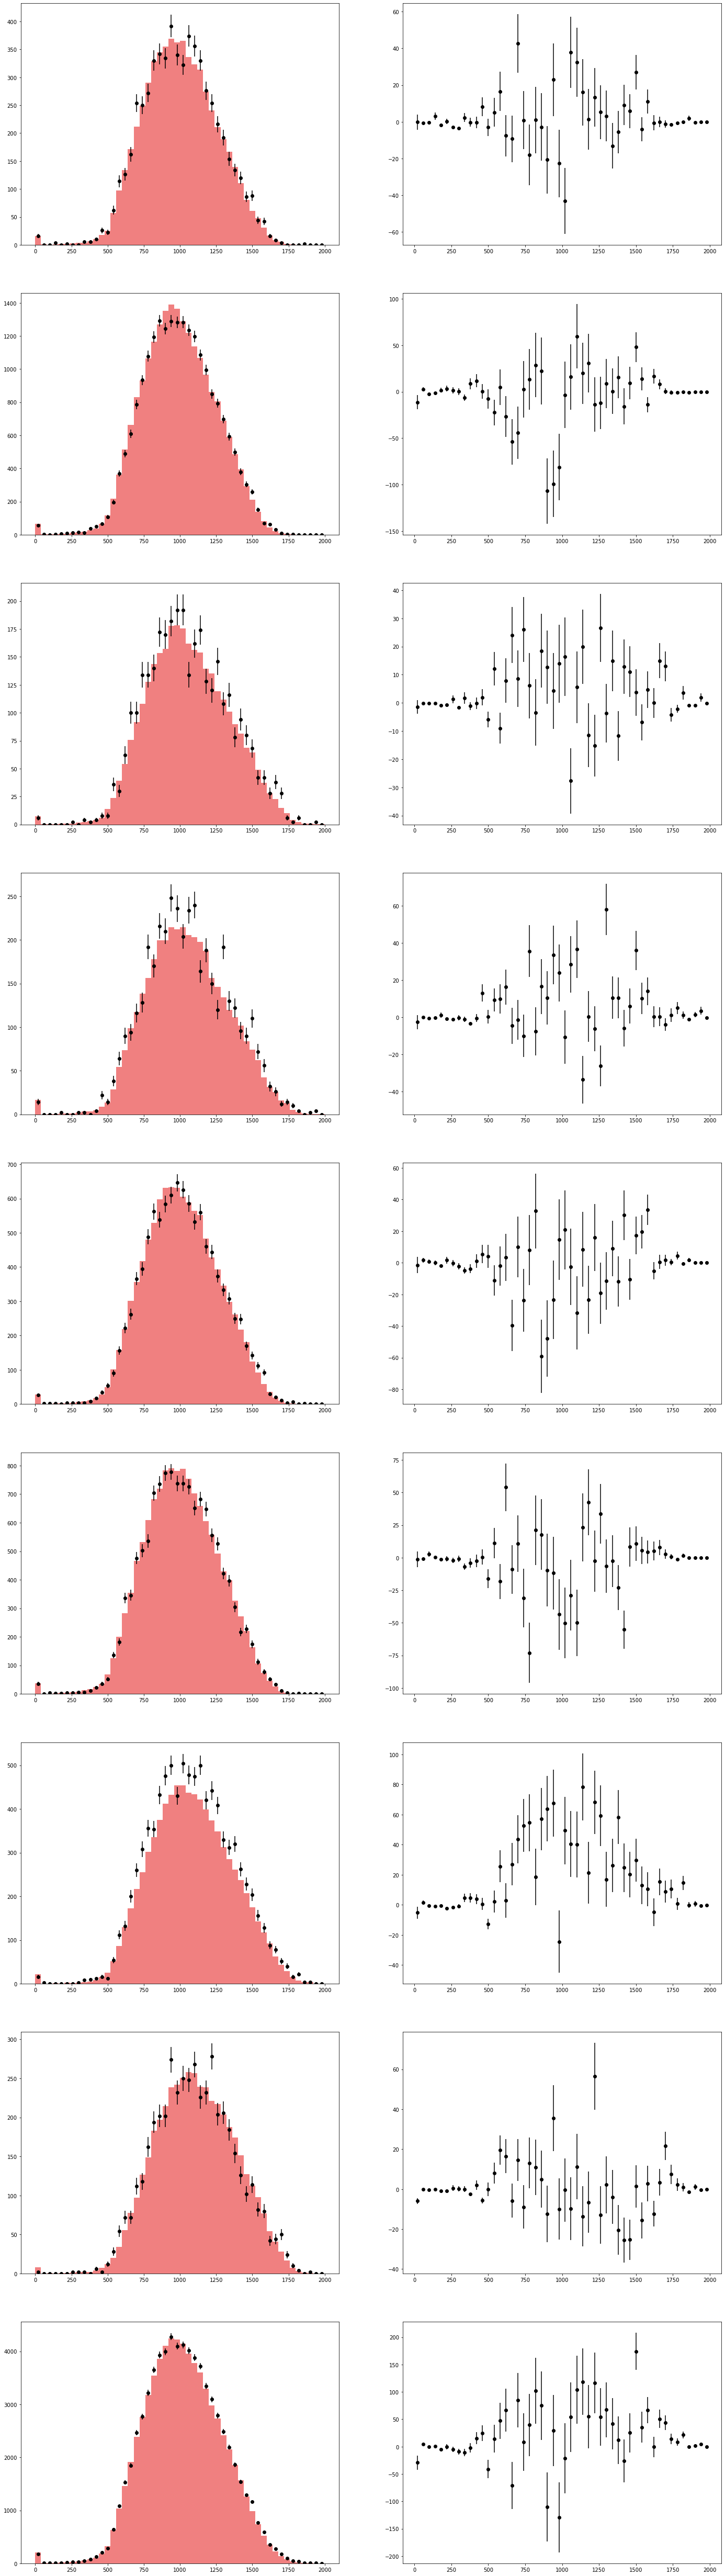

In [4]:
#var_ = "InvMass"
#var_ = "MX"
#var_ = "MissingMass"
#var_ = "MissingMass80GeV"
var_ = "MissingMass40GeV"
#var_ = "MissingMass10GeV"
#var_ = "MissingMass5GeV"

var_edges_ = "{}_edges".format( var_ )

fileNames_histos_data = {}
fileNames_histos_data["2017B"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017B.h5'
fileNames_histos_data["2017C1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017C1.h5'
fileNames_histos_data["2017E"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017E.h5'
fileNames_histos_data["2017F1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F1.h5'

fileNames_histos_data["2017C2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017C2.h5'
fileNames_histos_data["2017D"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017D.h5'
fileNames_histos_data["2017F2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F2.h5'
fileNames_histos_data["2017F3"] = 'histos-DoubleArm-Pt1_30-Pt2_20-2017F3.h5'

fileNames_histos_bkg = {}
fileNames_histos_bkg["2017B"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017B.h5'
fileNames_histos_bkg["2017C1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017C1.h5'
fileNames_histos_bkg["2017E"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017E.h5'
fileNames_histos_bkg["2017F1"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017F1.h5'

fileNames_histos_bkg["2017C2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017C2.h5'
fileNames_histos_bkg["2017D"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017D.h5'
fileNames_histos_bkg["2017F2"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017F2.h5'
fileNames_histos_bkg["2017F3"] = 'histos-DoubleArm-Pt1_30-Pt2_20-Bkg-2017F3.h5'

resample_factor_ = 20

fig, axes = plt.subplots( (len(fileNames_histos_data)+1), 2, figsize=(24,(len(fileNames_histos_data)+1)*10) )

histos_all_data = []
histos_all_bkg = []
histo_bins_  = None
bin_centres_ = None
histo_range_ = None
for idx_, key_ in enumerate( fileNames_histos_data ):
    print ( fileNames_histos_data[ key_ ] )
    histo_data_ = None
    histo_data_bins_ = None
    histo_data_sum_ = None
    histo_bkg_ = None
    histo_bkg_bins_ = None
    histo_bkg_sum_ = None
    with h5py.File( fileNames_histos_data[ key_ ], 'r' ) as f:
        dset_histo_ = f[ var_ ]
        histo_data_ = dset_histo_[:,:]
        dset_histo_bins_ = f[ var_edges_ ]
        histo_data_bins_ = dset_histo_bins_[:]
        histo_data_sum_ = np.sum( histo_data_, axis=0 )
        print ( histo_data_ )
        print ( histo_data_bins_ )
        print ( histo_data_sum_ )
    print ( fileNames_histos_bkg[ key_ ] )
    with h5py.File( fileNames_histos_bkg[ key_ ], 'r' ) as f:
        dset_histo_ = f[ var_ ]
        histo_bkg_ = dset_histo_[:,:]
        dset_histo_bins_ = f[ var_edges_ ]
        histo_bkg_bins_ = dset_histo_bins_[:]
        histo_bkg_sum_ = np.sum( histo_bkg_, axis=0 )
        print ( histo_bkg_ )
        print ( histo_bkg_bins_ )
        print ( histo_bkg_sum_ )
    
    histo_bins_ = histo_data_bins_
    bin_centres_ = ( histo_bins_[:-1] + histo_bins_[1:] )/2
    histo_range_ = ( histo_bins_[0], histo_bins_[-1] )

    axes[ idx_, 0 ].errorbar( bin_centres_, histo_data_sum_, yerr=np.sqrt( histo_data_sum_ ), fmt='o', color='black' )        
    axes[ idx_, 0 ].hist( bin_centres_, weights=( histo_bkg_sum_ / resample_factor_ ), bins=histo_bins_, color='lightcoral' )
    axes[ idx_, 1 ].errorbar( bin_centres_, ( histo_data_sum_ - histo_bkg_sum_ / resample_factor_ ), yerr=np.sqrt( histo_data_sum_ ), fmt='o', color='black' )
    
    histos_all_data.append( histo_data_sum_ )
    histos_all_bkg.append( histo_bkg_sum_ )
    
histo_data_sum_all = np.sum( histos_all_data, axis=0 )
histo_bkg_sum_all = np.sum( histos_all_bkg, axis=0 )
axes[ len(fileNames_histos_data), 0 ].errorbar( bin_centres_, histo_data_sum_all, yerr=np.sqrt( histo_data_sum_all ), fmt='o', color='black' )        
axes[ len(fileNames_histos_data), 0 ].hist( bin_centres_, weights=( histo_bkg_sum_all / resample_factor_ ), bins=histo_bins_, color='lightcoral' )
axes[ len(fileNames_histos_data), 1 ].errorbar( bin_centres_, ( histo_data_sum_all - histo_bkg_sum_all / resample_factor_ ), yerr=np.sqrt( histo_data_sum_all ), fmt='o', color='black' )


0 2017B
output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20.h5
output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5
output/output-UL2017B-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5
Data / Background = 1.0172096908939015
1 2017C1
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20_0.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20_1.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_0.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_1.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_2.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_3.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_4.h5
output/output-UL2017C1-DoubleArm-Pt1_30-Pt2_20-Rnd-Res20_5.h5
Data / Background = 0.9920007334571043
2 2017E
output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_0.h5
output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_1.h5
output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_2.h5
output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_3.h5
output/output-UL2017E-DoubleArm-Pt1_30-Pt2_20_

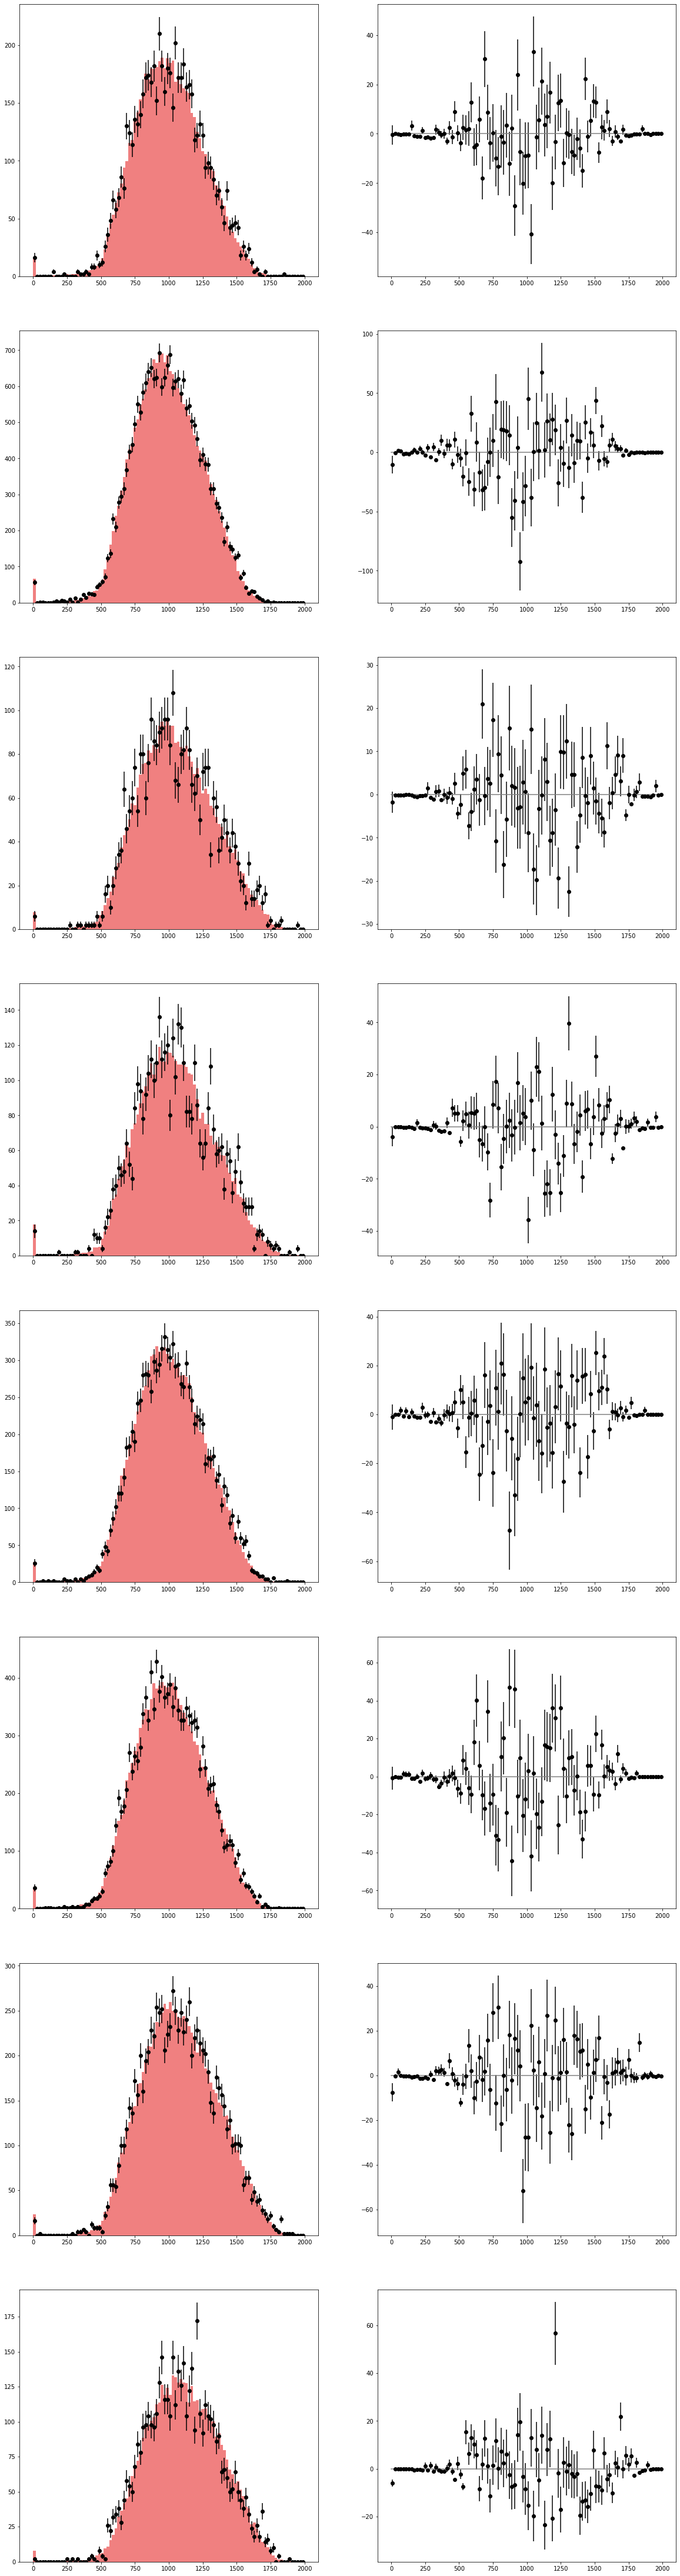

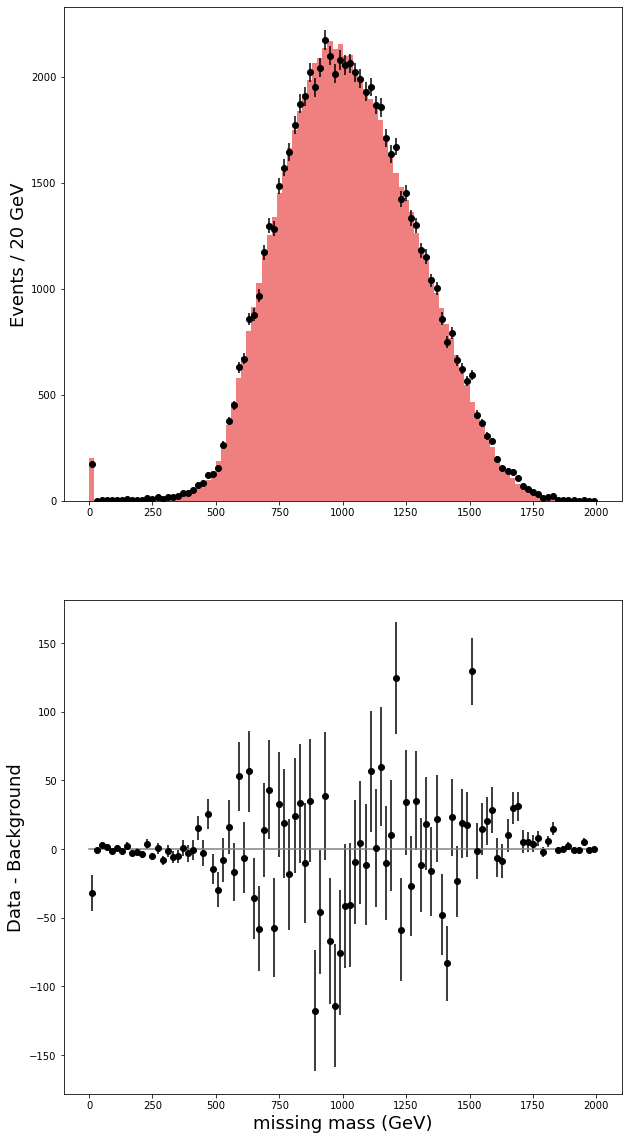

In [9]:
# From dataframe

resample_factor_ = 20
rescale_bkg_ = True

#var_ = "MX"
var_ = "MissingMass20GeV"
savefig_ = False

fig, axes = plt.subplots( len(fileNames_data), 2, figsize=(20,len(fileNames_data)*10) )

histos_all_data = []
histos_all_bkg = []
histos_bkg_sum_corr = []
histo_bins_ = None
bin_centres_ = None
histo_range_ = None
with pd.HDFStore( "reduced-data-store-DoubleArm-Pt1_30-Pt2_20.h5", 'r' ) as store_data_:
    with pd.HDFStore( "reduced-data-store-DoubleArm-Pt1_30-Pt2_20-Bkg.h5", 'r' ) as store_bkg_:
        for idx_, key_ in enumerate( fileNames_data ):
            print ( idx_, key_ )
            histos_data_ = []
            for file_ in fileNames_data[ key_ ]:
                print ( file_ )
                df_ = store_data_[ file_ ]
                counts_, bin_edges_ = np.histogram( df_[ df_names_[ var_ ] ], bins=bins_[ var_ ], range=ranges_[ var_ ] )
                if len( histos_all_data ) == 0:
                    histo_bins_ = bin_edges_
                    bin_centres_ = ( histo_bins_[:-1] + histo_bins_[1:] )/2
                    histo_range_ = ( histo_bins_[0], histo_bins_[-1] )

                histos_data_.append( counts_ )
                histos_all_data.append( counts_ )

            histo_data_sum_ = np.sum( histos_data_, axis=0 )

            histos_bkg_ = []
            for file_ in fileNames_bkg[ key_ ]:
                print ( file_ )
                df_ = store_bkg_[ file_ ]
                counts_, bin_edges_ = np.histogram( df_[ df_names_[ var_ ] ], bins=bins_[ var_ ], range=ranges_[ var_ ] )

                histos_bkg_.append( counts_ )
                histos_all_bkg.append( counts_ )

            histo_bkg_sum_ = np.sum( histos_bkg_, axis=0 )
            
            sum_data_ = np.sum( histo_data_sum_ )
            sum_bkg_ = np.sum( histo_bkg_sum_ )
            print ( "Data / Background = {}".format( sum_data_ / ( sum_bkg_ / resample_factor_ ) ) )
            histo_bkg_sum_corr_ = None
            if rescale_bkg_:
                rescale_factor_bkg_ = ( sum_data_ / ( sum_bkg_ / resample_factor_ ) )
                histo_bkg_sum_corr_ = histo_bkg_sum_ * rescale_factor_bkg_
            else:
                histo_bkg_sum_corr_ = histo_bkg_sum_
            histos_bkg_sum_corr.append( histo_bkg_sum_corr_ )
            
            axes[ idx_, 0 ].errorbar( bin_centres_, histo_data_sum_, yerr=np.sqrt( histo_data_sum_ ), fmt='o', color='black' )
            axes[ idx_, 0 ].hist( bin_centres_, weights=( histos_bkg_sum_corr[-1] / resample_factor_ ), bins=histo_bins_, color='lightcoral' )
            axes[ idx_, 1 ].plot( (histo_range_[0], histo_range_[1]), (0., 0.), color="gray" )
            axes[ idx_, 1 ].errorbar( bin_centres_, ( histo_data_sum_ - histos_bkg_sum_corr[-1] / resample_factor_ ), yerr=np.sqrt( histo_data_sum_ ), fmt='o', color='black' )

print ( "Sum of all periods." )

fig_sum_all, axes_sum_all = plt.subplots( 2, 1, figsize=(10,20) )

histo_data_sum_all = np.sum( histos_all_data, axis=0 )
histo_bkg_sum_all = None
if rescale_bkg_:
    histo_bkg_sum_all = np.sum( histos_bkg_sum_corr, axis=0 )
else:
    histo_bkg_sum_all = np.sum( histos_all_bkg, axis=0 )

sum_data_ = np.sum( histo_data_sum_all )
sum_bkg_ = np.sum( histo_bkg_sum_all )
print ( "Data / Background = {}".format( sum_data_ / ( sum_bkg_ / resample_factor_ ) ) )

axes_sum_all[ 0 ].errorbar( bin_centres_, histo_data_sum_all, yerr=np.sqrt( histo_data_sum_all ), fmt='o', color='black' )        
axes_sum_all[ 0 ].hist( bin_centres_, weights=( histo_bkg_sum_all / resample_factor_ ), bins=histo_bins_, color='lightcoral' )
axes_sum_all[ 1 ].plot( (histo_range_[0], histo_range_[1]), (0., 0.), color="gray" )
axes_sum_all[ 1 ].errorbar( bin_centres_, ( histo_data_sum_all - histo_bkg_sum_all / resample_factor_ ), yerr=np.sqrt( histo_data_sum_all ), fmt='o', color='black' )
axes_sum_all[ 0 ].set_ylabel( "Events / {:.0f} GeV".format( ( ranges_[ var_ ][1] - ranges_[ var_ ][0] ) / bins_[ var_ ] ), fontsize=18 )
axes_sum_all[ 1 ].set_xlabel( "missing mass (GeV)", fontsize=18 )
axes_sum_all[ 1 ].set_ylabel( "Data - Background", fontsize=18 )
#axes_sum_all[ 0 ].set_xlim( 500., 1100. )
#axes_sum_all[ 1 ].set_xlim( 500., 1100. )
if savefig_:
    plt.savefig( "Data_Bkg_{}.pdf".format( var_ ) )


### References

In [ ]:
np.info( np.sum )

In [ ]:
np.sum( [ np.ones(5), np.ones(5) ], axis=0 )

In [ ]:
import time
time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() )
time_s_ = time.time()
time.sleep(3)
time_e_ = time.time()
print ( time_e_ - time_s_ )

In [ ]:
np.info( pd.HDFStore )